In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '../../python')
from fitv3 import *
from scipy import interpolate

plotter = Plotter()



import Loader as ms


#processedDataDir = "../data/processedv4/"


#This is the path to were you saved the processed correlators.
processedDataDir = "/home/superpions/processed_data/unbroken_H0/"
#processedDataDir = "../../python/"



gdir = '../gnuplot_data/'


mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('font', size = '14')

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

def ylabel(ax, label, fts = 14):
    ax.set_ylabel(label, fontsize=fts)
def xlabel(ax, label, fts = 14):
    ax.set_xlabel(label, fontsize=fts)       

#%load_ext gnuplot_kernel


dt=0.72
chi0 = 5.0


def getNameStr(m, v):
    res = "{}".format(m).split('.')
    mStr = "m-0" + res[0][1:] + res[1]
    while len(mStr)<9:
        mStr+='0'
    vStr = "{}".format(v)
    vStr = "N0" + vStr if v < 100 else "N" + vStr
    return "zeroHlongDiffuse_" + vStr + "_" + mStr + "_h000000_c00500"

In [2]:
loader=dict()
dms=dict()
dataFn=dict()
#masses = [-4.76000, -4.74500 ,-4.73366,-4.72800, -4.72000,-4.71000,-4.70052, -4.66000] 
masses = [-4.78000,-4.76000,-4.73366,-4.72800, -4.72000,-4.71000,-4.70052, -4.68000] 
mc = -4.81100
reducedMasses = (mc - np.asarray(masses)) / mc
for m in masses:
    loader[m] = dict()
    dms[m] = dict()
    dataFn[m] = dict()
volumes = [96]

In [3]:
fitter = dict()

for m in masses:
    fitter[m] = dict()
    for v in volumes:
        dataFn[m][v] = getNameStr(m, v)
        fn = "../../run_H0/" + dataFn[m][v] + "/" + dataFn[m][v] + ".h5"
        loader[m][v] = ms.Loader(
            fn,
            removemean=True,
            starttime=8000,
            nblocks=15)
        dms[m][v] = ms.DataManager(fn, processedDataDir)
        fitter[m][v] = Fitter(dms[m][v], 1.0, 1.0, L = float(v))
        #res = dms[m][v].load("oxoxp_phi0123_xyz", False)
        #dms[m][v].save(res, "oxoxp_phi0123_xyz", np.arange(len(res.mean)))


In [4]:
def getSlidingMass(fit,L):
    res = []
    resErr = []
    for i in range(0,int(L/2-8)):
        fit.fit("oxoxp", "phi0123",  minInd=i,maxInd=L-i)
        res.append(fit.par["oxoxp"]["phi0123"][1])
        resErr.append(fit.parErr["oxoxp"]["phi0123"][1])
    return StatResult((res, resErr))


def constantFit(const, plateau, endPlateau, guess=0.2):

    modelC = lambda par : par[0]


    res = const.mean[plateau:endPlateau]
    resErr = const.err[plateau:endPlateau]
    chi2C2 = lambda par : np.sum(np.square((res - modelC(par)) / resErr ))
    fitC2 = Minuit(chi2C2, [guess], name=["b"])

    fitC2.errordef = Minuit.LEAST_SQUARES

    #fit.limits = []

    fitC2.migrad()
    fitC2.minos();


    return fitC2.values['b'],fitC2.errors['b']

def plotConst(fit, fitErr, plateau, endPlateau):
    xs = [plateau, endPlateau]
    ys = np.asarray([fit, fit])
    errs = np.asarray([fitErr, fitErr])



    plt.fill_between(xs, ys - errs,ys + errs, linewidth=0, zorder=1, color='r')


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[in

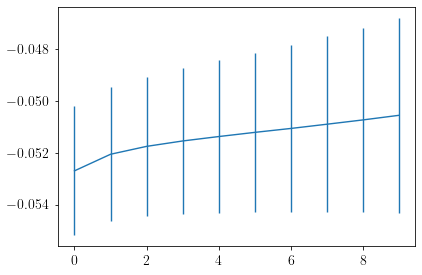

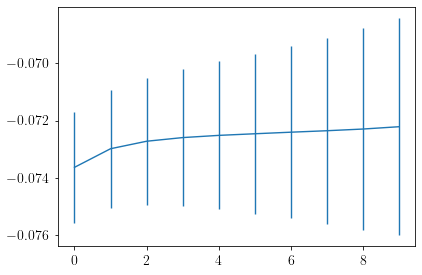

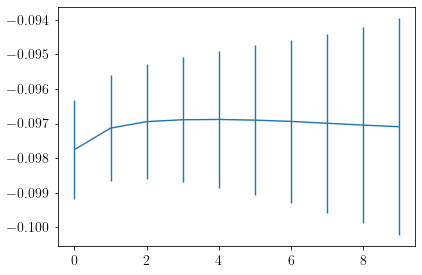

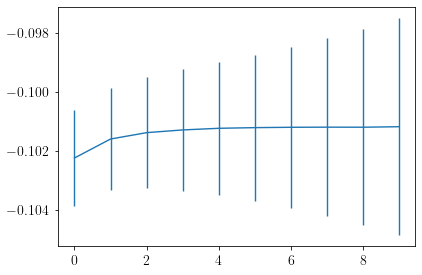

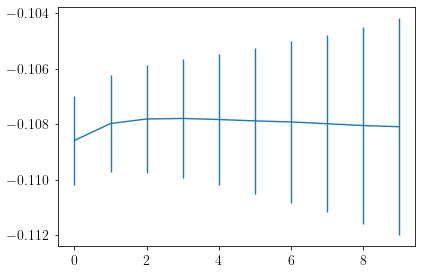

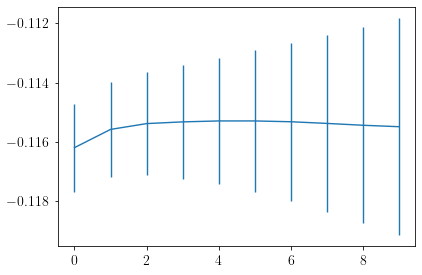

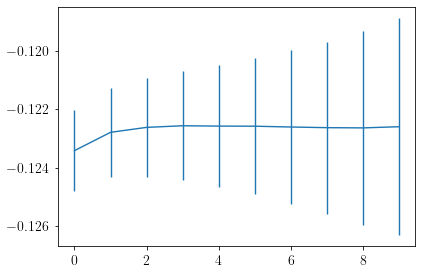

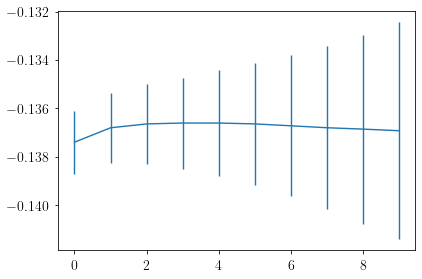

In [5]:
for m in masses:
    last=10
    x,res = dms[m][v].load("oxoxpeffmasses_phi0123_xyz")
    plt.figure()
    plt.errorbar(x[:last], res.mean[:last], res.err[:last])
    #plt.yscale('log')
    #fitter[m][v].plot("oxoxp", "phi0123")

As in this case the effective masses converges quickly, I extract the inverse correlation length the second effecive mass.

In [6]:
invCor = []
invCorErr = []
for m in masses:
    last=10
    x,res = dms[m][v].load("oxoxpeffmasses_phi0123_xyz")
    mean, err = constantFit(res, 1, 5)
    invCor.append(mean)
    invCorErr.append(err)

/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:683: ComplexWarning: Casting complex values to real discards the imaginary part
  fm = migrad(ncall, self._tolerance)
/home/adrienflorio/.local/lib/python3.8/site-packages/iminuit/minuit.py:1370: ComplexWarning: Casting complex values to real discards the imaginary part
  me = minos(self._var2pos[par], ncall, self._tolerance)


<ErrorbarContainer object of 3 artists>

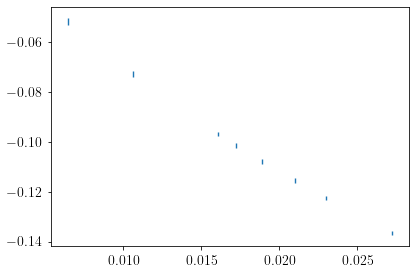

In [7]:
plt.errorbar(reducedMasses, invCor, invCorErr, ls="none")

In [8]:
omega = 0.8
nu = 0.7377

In [9]:
    scaling = lambda x, par : par[0] * x**(nu) *(1.0 + par[1] * x**(omega * nu) )


    chi2 = lambda par : np.sum(np.square((invCor - scaling(reducedMasses, par)) / invCorErr ))
    fit = Minuit(chi2, [0.000001, 10.0], name=["xim1", "xim1+"])

    fit.errordef = Minuit.LEAST_SQUARES

    #fit.limits = []

    fit.migrad()
    fit.minos();

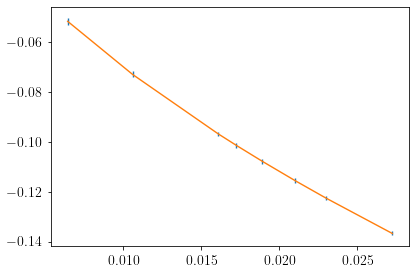

In [10]:
plt.errorbar(reducedMasses, invCor, invCorErr, ls='none')

plt.plot(reducedMasses, scaling(reducedMasses, np.asarray(fit.values)))
#plt.plot(reducedMasses, scaling(reducedMasses, [1.01*np.asarray(fit.values)[0], np.asarray(fit.values)[1]]))


#plt.xscale("log")
#plt.yscale("log")

In [11]:
fit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1547                     │              Nfcn = 177              │
│ EDM = 2.96e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xim1  │   -2.27   │   0.05    │   -0.05    │    0.05    │         │         │       │
│ 1 │ xim1+ │   -1.18   │   0.17    │   -0.17    │    0.17    │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │         xim1          │         xim1+         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.05   │   0.05    │   -0.17   │   0.17    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────┐
│       │    xim1   xim1+ │
├───────┼─────────────────┤
│  xim1 │ 0.00211  0.0078 │
│ xim1+ │  0.0078  0.0296 │
└───────┴─────────────────┘

Universal ratio:

In [12]:
C1 = 0.209
C1Err = 0.011

xim1 = 2.27
xim1Err = 0.05

B = 0.544
Berr=0.004

In [13]:
B**2 / C1 * (1.0 /  xim1)**3 

0.12105254980990032

In [14]:
C1

0.209

In [2]:
1.0 / 0.06

16.666666666666668